In [21]:
%run Imports.ipynb
import numpy as np
import time
import warnings
import pandas as pd
import pickle

import quantpy as qp

from collections import defaultdict, Counter
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore', category=np.ComplexWarning)

In [22]:
titlesize = 40
labelsize = 66
legendsize = 46
xticksize = 48
yticksize = xticksize
linewidth = 3
fontsize = 60
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

In [2]:
with open('../data/states.pkl', 'rb') as f:
    states = pickle.load(f)
states

,name,state,title,povm,n_meas
0,zero1,"Quantum object\narray([[1.+0.j, 0.+0.j],\n ...",$|0\rangle$,proj-set,1000
1,pure1,"Quantum object\narray([[0.85355+0.j , 0.25 ...",$\cos\frac{\pi}{8}|0\rangle + \sin\frac{\pi}{8...,proj-set,1000
2,fullymixed1,"Quantum object\narray([[0.5+0.j, 0. +0.j],\n ...",1-qubit fully mixed state,proj-set,1000
3,zero2,"Quantum object\narray([[1.+0.j, 0.+0.j, 0.+0.j...",$|00\rangle$,proj-set,10000
4,ghz2,"Quantum object\narray([[0.5+0.j, 0. +0.j, 0. +...",$|\Phi^+\rangle$,proj-set,10000
5,fullymixed2,"Quantum object\narray([[0.25+0.j, 0. +0.j, 0....",2-qubit fully mixed state,proj-set,10000
6,ghz3,"Quantum object\narray([[0.5+0.j, 0. +0.j, 0. +...",3-qubit GHZ state,proj-set,100000


In [3]:
with open('../data/processes.pkl', 'rb') as f:
    processes = pickle.load(f)
processes

,name,process,title,povm,n_meas
0,hadamard,Quantum channel with Choi matrix\narray([[ 0.5...,Hadamard gate,proj-set,1000
1,rxpi2,Quantum channel with Choi matrix\narray([[0.5+...,$RX(\pi/2)$,proj-set,1000
2,rypi2,Quantum channel with Choi matrix\narray([[ 0.5...,$RY(\pi/2)$,proj-set,1000
3,dep1,Quantum channel with Choi matrix\narray([[0.5+...,Fully depolarizing 1-qubit,proj-set,1000
4,cnot,Quantum channel with Choi matrix\narray([[1.+0...,CNOT,proj-set,100000
5,ms,Quantum channel with Choi matrix\narray([[ 0.5...,Mølmer–Sørensen gate,proj-set,100000


In [5]:
state = states.iloc[0]
tmg = qp.StateTomograph(state['state'])
tmg.experiment(state['n_meas'], povm=state['povm'])
interval = qp.MomentInterval(tmg, n_points=1000)
dist, CLs = interval()
state_hat = tmg.point_estimate(physical=False)
distance_hat = qp.hs_dst(state_hat, state['state'])

In [29]:
N_REPEATS = 1000
N_POINTS = 1000

states_results = defaultdict(list)

for i in range(len(states)):
    state = states.iloc[i]
    for _ in tqdm(range(N_REPEATS)):
        tmg = qp.StateTomograph(state['state'])
        tmg.experiment(state['n_meas'], povm=state['povm'])
        interval = qp.MomentInterval(tmg, n_points=N_POINTS)
        dist, CLs = interval()
        state_hat = tmg.point_estimate(physical=False)
        distance_hat = qp.hs_dst(state_hat, state['state'])
        ub_cls = np.where(distance_hat < dist)[0]
        epsilon = 1 - np.where(distance_hat < dist)[0][0] / N_POINTS if len(ub_cls) != 0 else 0
        states_results[state['name']].append(epsilon)
    states_results[state['name']].sort()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.02, 0.9, 'a)')

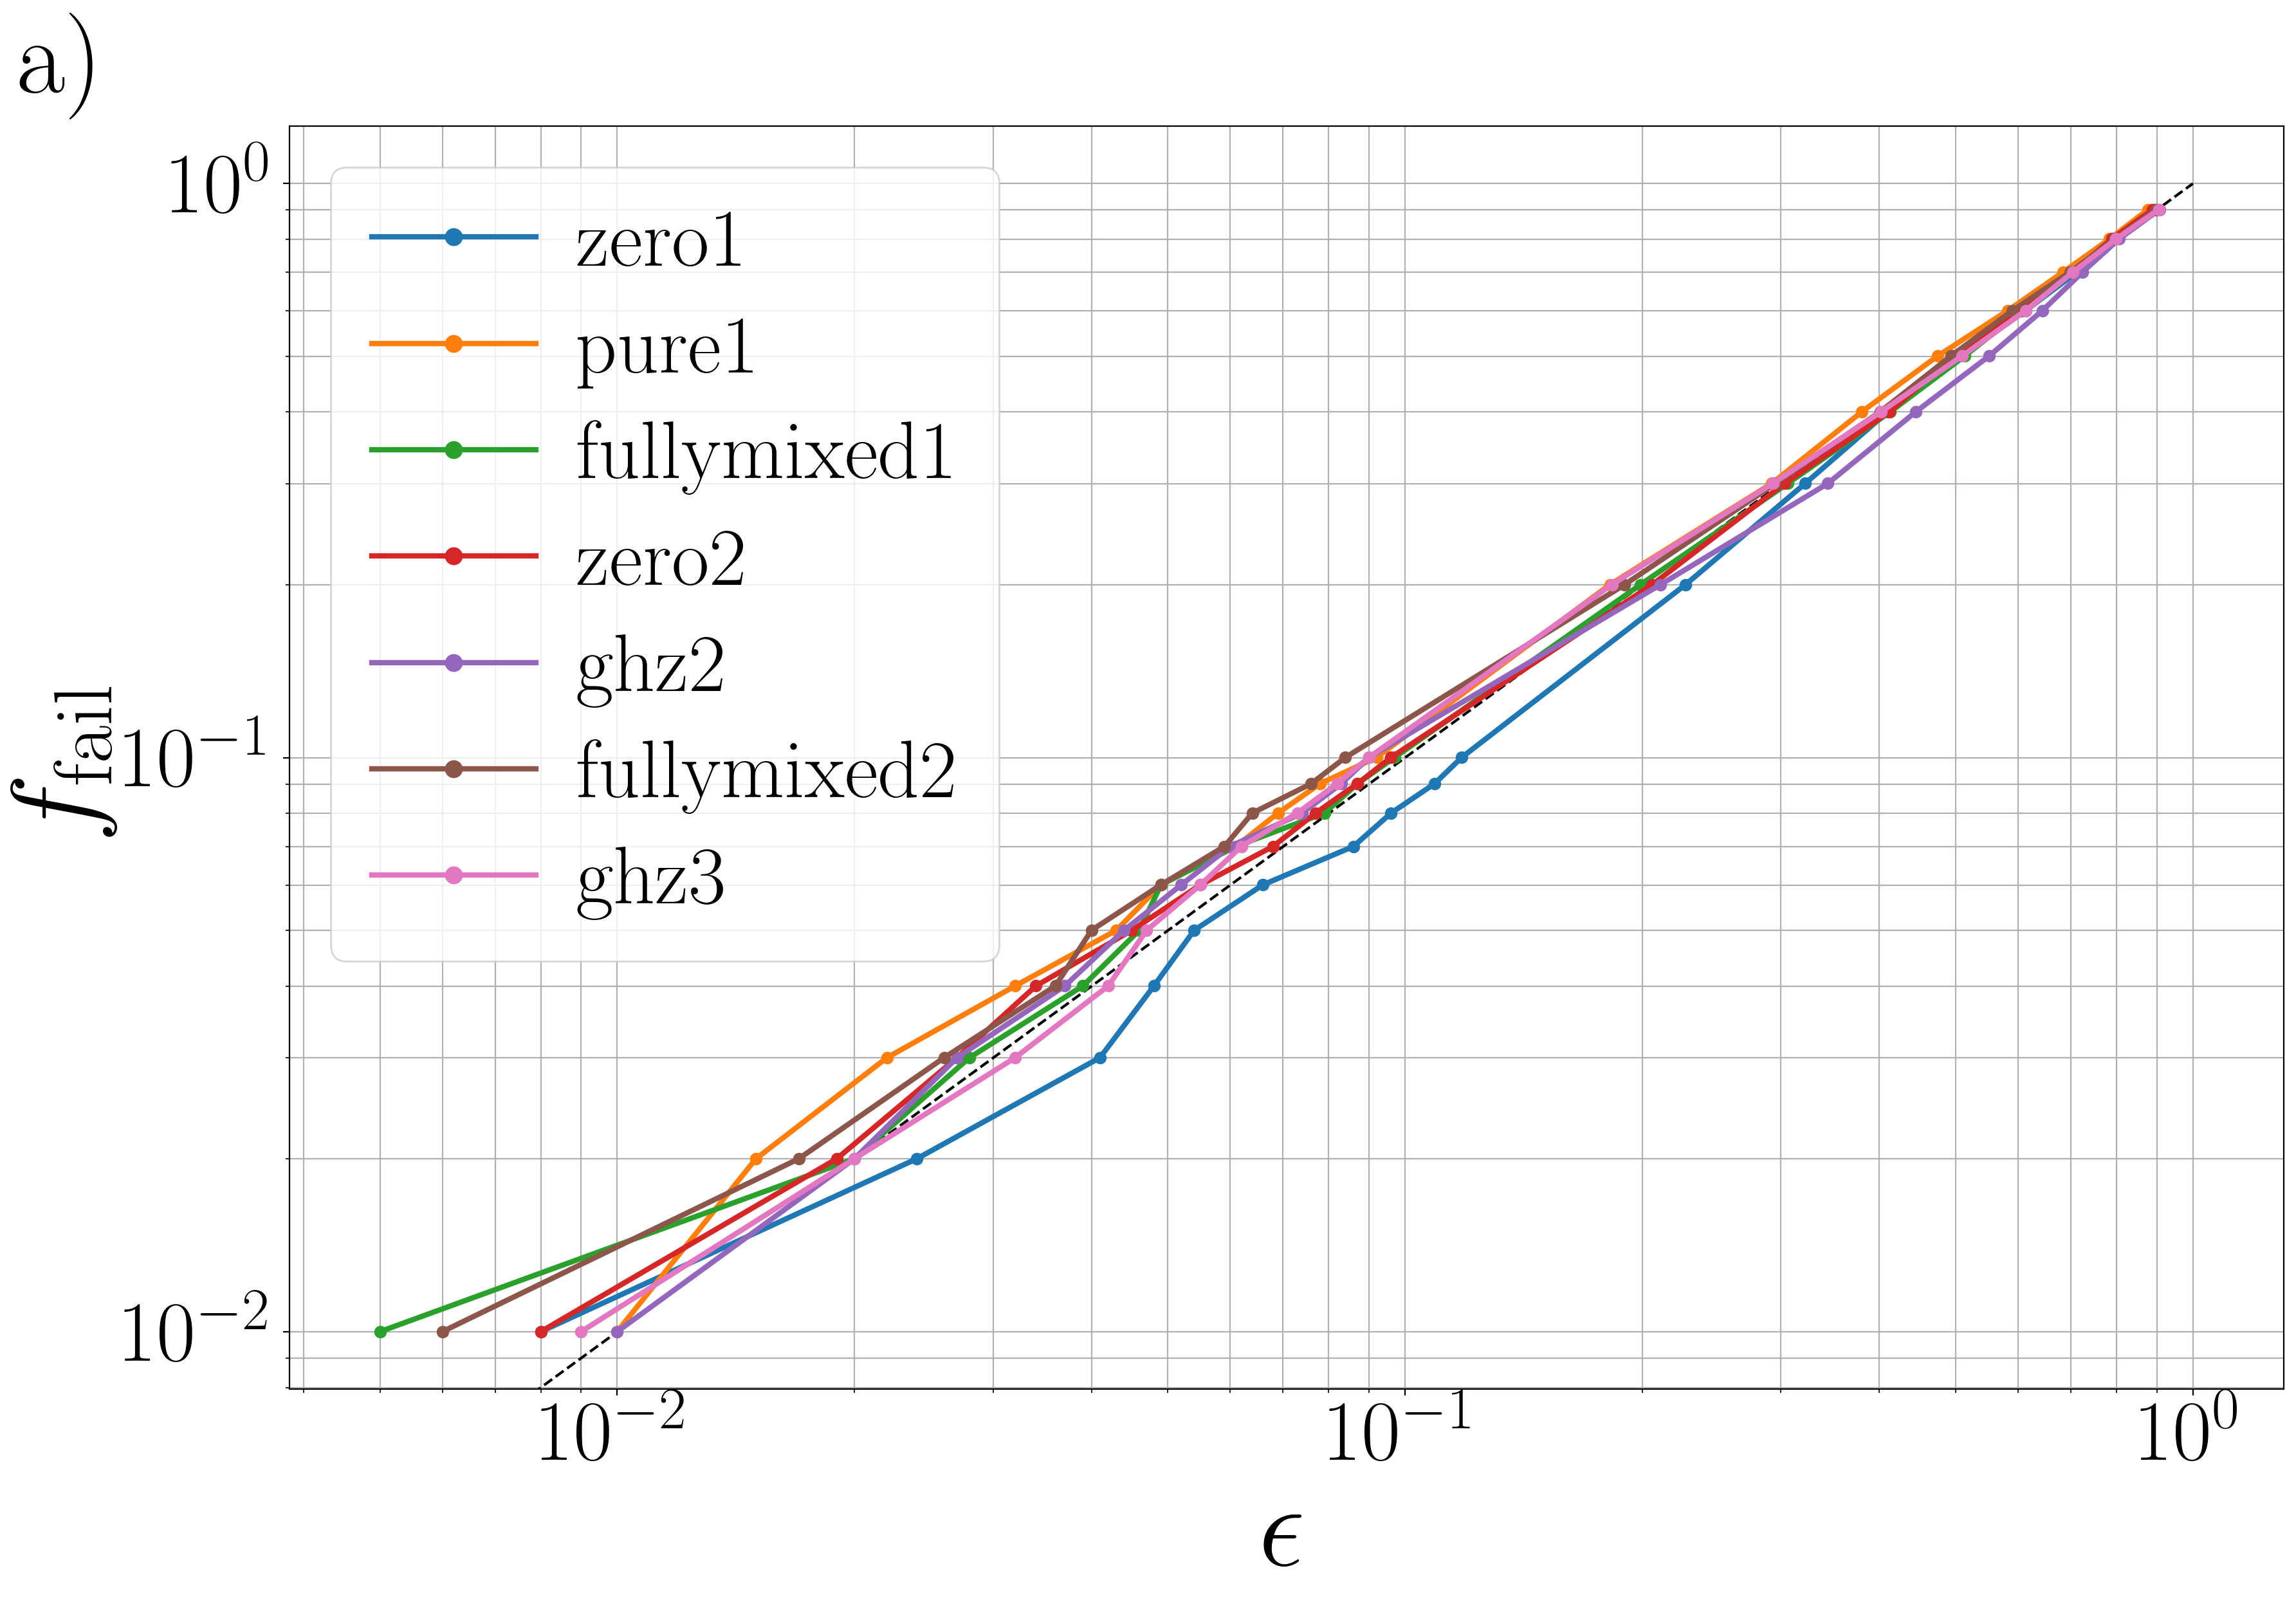

In [39]:
# conf_levels = np.concatenate((np.arange(0.1, 0.9, 0.1), np.arange(0.9, 1, 0.01)))
indices = np.concatenate((np.arange(10, 100, 10), np.arange(100, 1000, 100)))
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('$f_{\\rm fail}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), '--k')
for name, results in states_results.items():
    plt.plot(np.asarray(results)[indices], np.linspace(0, 1, N_POINTS)[indices], 
             '-o', label=name, linewidth=3)
plt.legend()
plt.figtext(0.02, 0.9, "a)")

In [38]:
np.linspace(0, 1, N_POINTS)[indices]

array([0.01001, 0.02002, 0.03003, 0.04004, 0.05005, 0.06006, 0.07007,
       0.08008, 0.09009, 0.1001 , 0.2002 , 0.3003 , 0.4004 , 0.5005 ,
       0.6006 , 0.7007 , 0.8008 , 0.9009 ])

In [4]:
N_REPEATS = 1000
N_POINTS = 1000
CONFIDENCE_LEVELS = [0.5, 0.75, 0.9, 0.95, 0.99]

states_results = defaultdict(list)

for _, state in states.iterrows():
    results = Counter()
    for _ in tqdm(range(N_REPEATS)):
        tmg = qp.StateTomograph(state['state'])
        tmg.experiment(state['n_meas'], povm=state['povm'])
        interval = qp.MomentInterval(tmg, n_points=N_POINTS)
        dist, CLs = interval()
        state_hat = tmg.point_estimate(physical=False)
        distance_hat = qp.hs_dst(state_hat, state['state'])
        for cl in CONFIDENCE_LEVELS:
            if distance_hat < dist[int(cl * N_POINTS)]:
                results[cl] += 1
    
    states_results['name'].append(state['name'])
    for key, value in results.items():
        states_results[key].append(value / N_REPEATS)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
pd.DataFrame(states_results)

,name,0.75,0.9,0.95,0.99,0.5
0,zero1,0.737,0.895,0.943,0.987,0.482
1,pure1,0.754,0.913,0.958,0.987,0.505
2,fullymixed1,0.735,0.888,0.942,0.983,0.484
3,zero2,0.755,0.896,0.952,0.987,0.508
4,ghz2,0.733,0.886,0.941,0.980,0.487
5,fullymixed2,0.747,0.907,0.955,0.993,0.509
6,ghz3,0.735,0.886,0.938,0.982,0.500


In [56]:
N_REPEATS = 1000
N_POINTS = 1000

processes_results = defaultdict(list)

for i in range(0, 5):
    process = processes.iloc[i]
    for _ in tqdm(range(N_REPEATS)):
        tmg = qp.ProcessTomograph(process['process'], input_states='proj4')
        tmg.experiment(process['n_meas'], povm=process['povm'])
        interval = qp.MomentInterval(tmg, n_points=N_POINTS)
        dist, CLs = interval()
        process_hat = tmg.point_estimate(cptp=False, states_physical=False)
        distance_hat = qp.hs_dst(process_hat.choi, process['process'].choi)
        ub_cls = np.where(distance_hat < dist)[0]
        epsilon = 1 - np.where(distance_hat < dist)[0][0] / N_POINTS if len(ub_cls) != 0 else 0
        processes_results[process['name']].append(epsilon)
    processes_results[process['name']].sort()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
N_REPEATS = 1000
N_POINTS = 1000
CONFIDENCE_LEVELS = [0.5, 0.75, 0.9, 0.95, 0.99]

processes_results = defaultdict(list)

for _, process in processes.iterrows():
    results = Counter()
    for _ in tqdm(range(N_REPEATS)):
        tmg = qp.ProcessTomograph(process['process'])
        tmg.experiment(process['n_meas'], povm=process['povm'])
        interval = qp.MomentInterval(tmg, n_points=N_POINTS)
        dist, CLs = interval()
        process_hat = tmg.point_estimate(cptp=False)
        distance_hat = qp.hs_dst(process_hat.choi, process['process'].choi)
        for cl in CONFIDENCE_LEVELS:
            if distance_hat < dist[int(cl * N_POINTS)]:
                results[cl] += 1
    
    processes_results['name'].append(process['name'])
    for key, value in results.items():
        processes_results[key].append(value / N_REPEATS)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0.02, 0.9, 'a)')

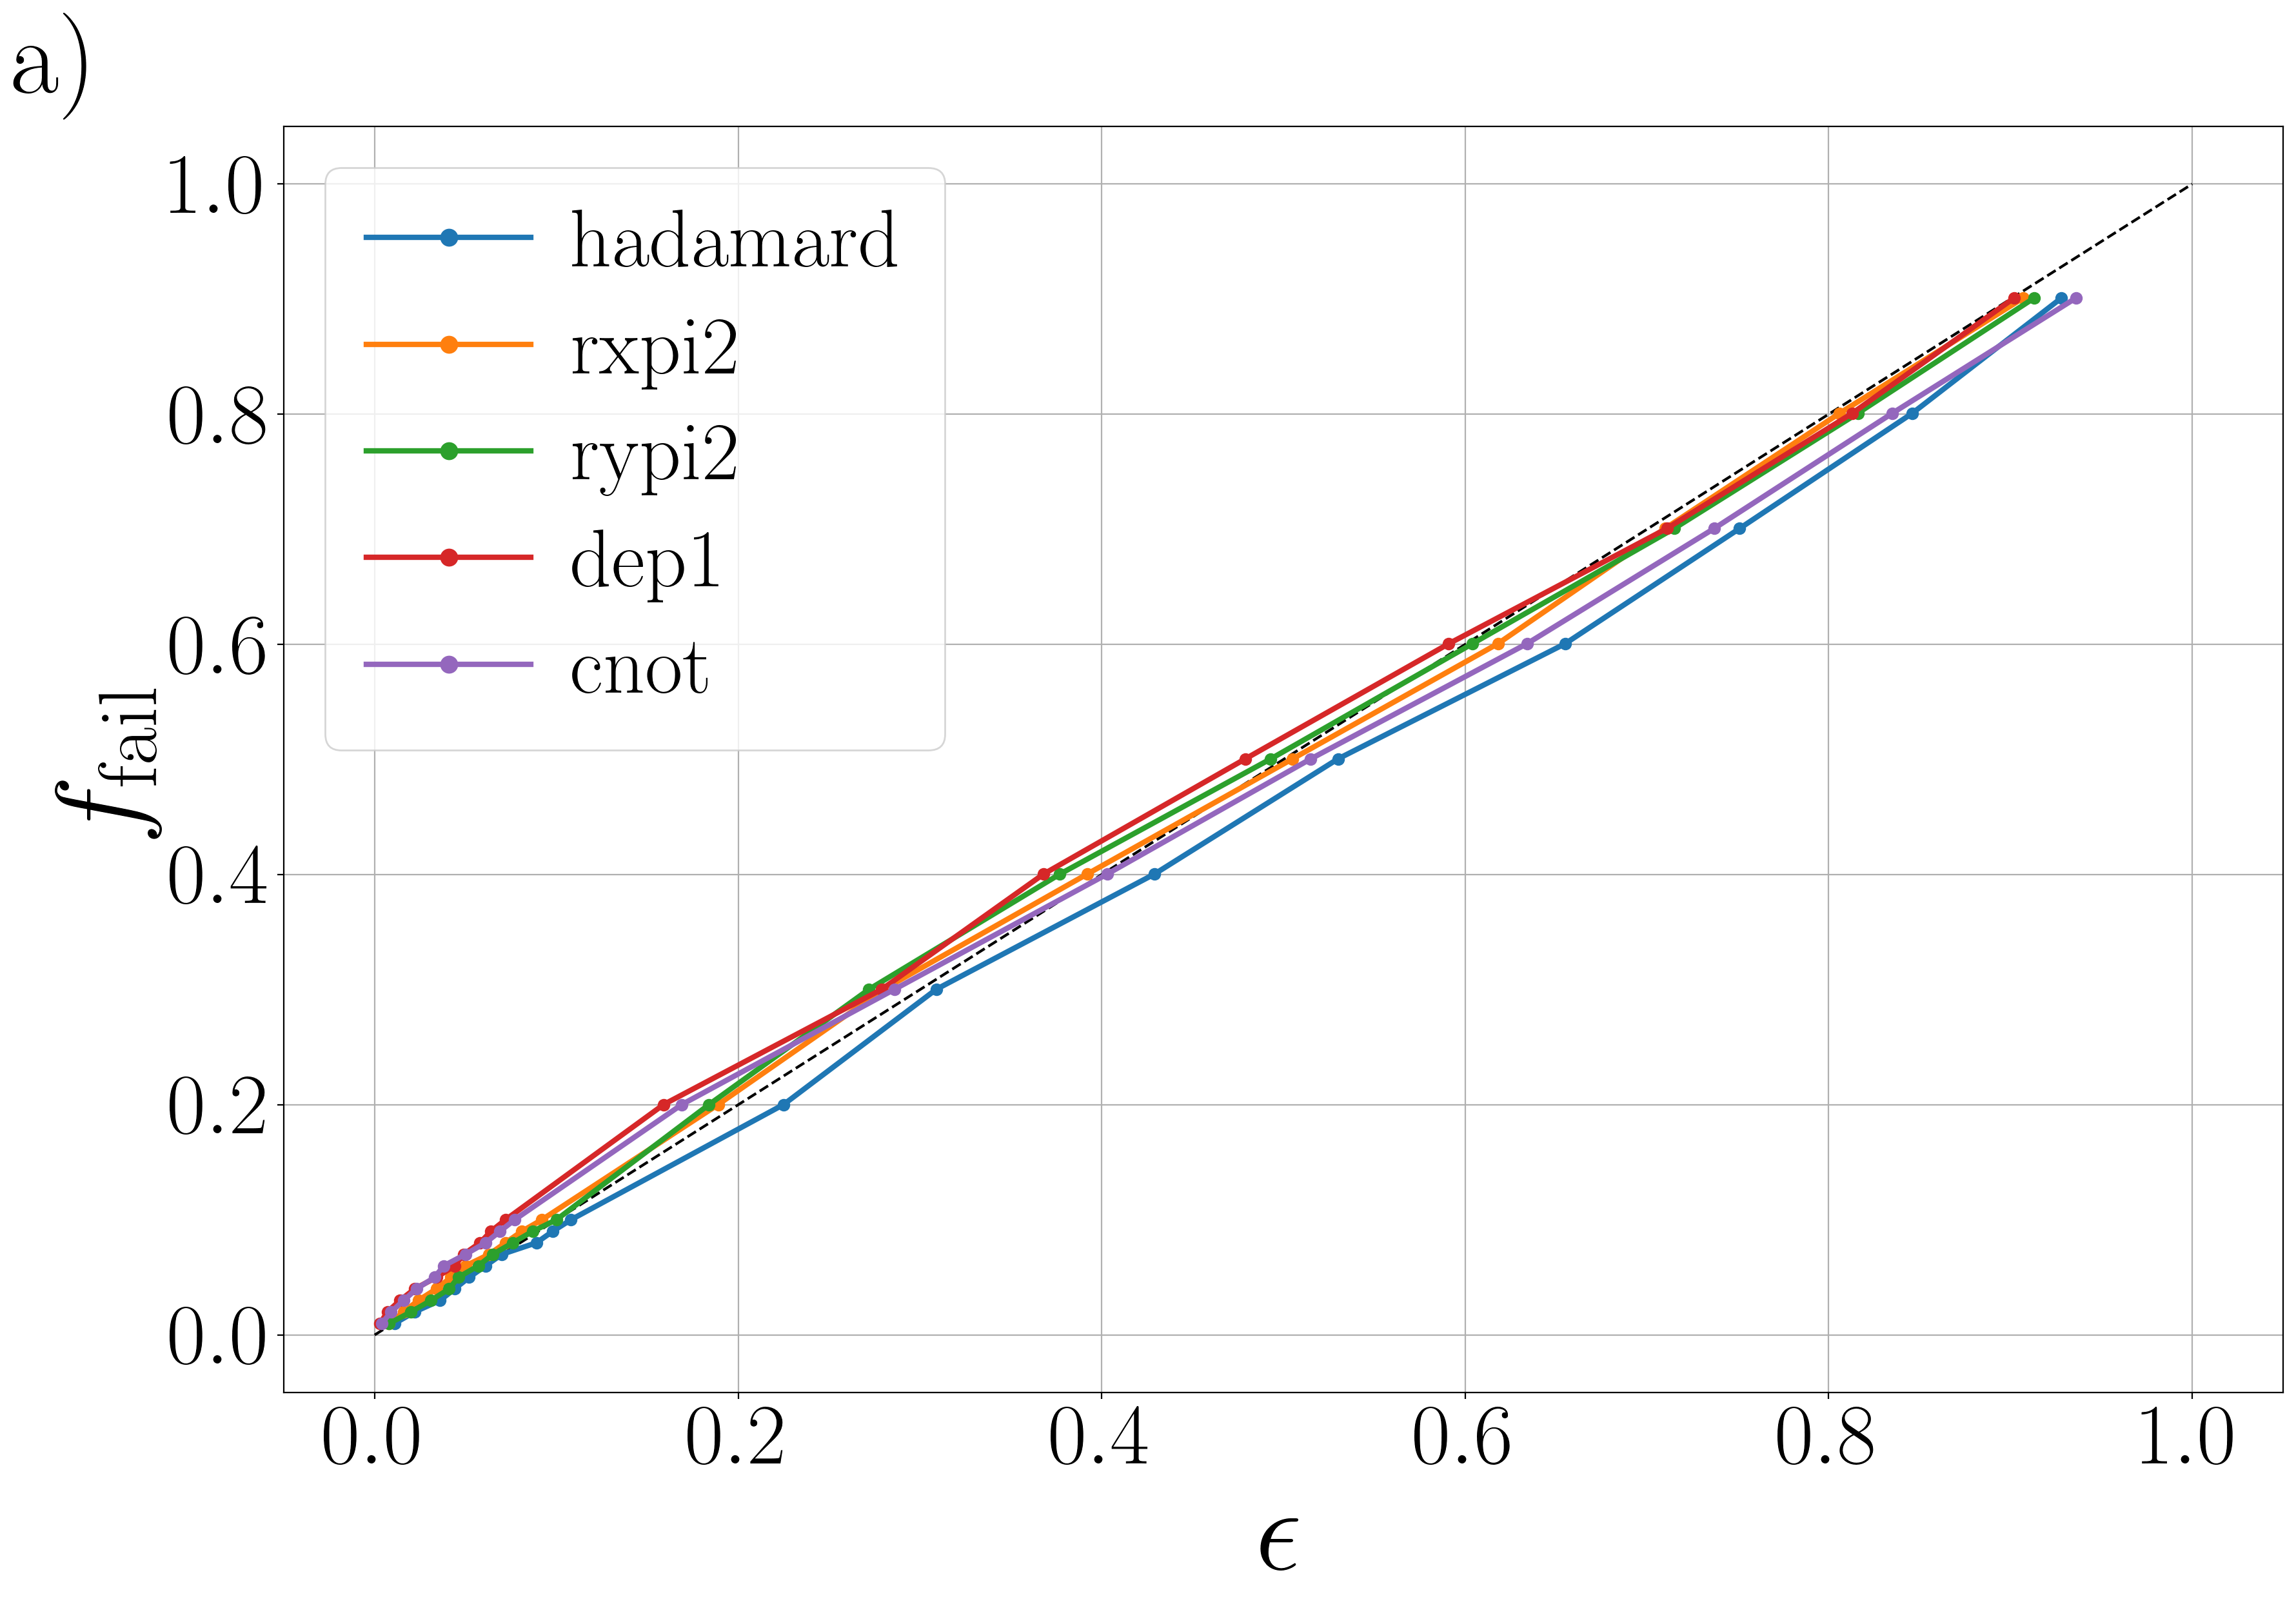

In [55]:
# conf_levels = np.concatenate((np.arange(0.1, 0.9, 0.1), np.arange(0.9, 1, 0.01)))
indices = np.concatenate((np.arange(10, 100, 10), np.arange(100, 1000, 100)))
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('$f_{\\rm fail}$')
# plt.xscale('log')
# plt.yscale('log')
plt.grid(which='both')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), '--k')
for name, results in processes_results.items():
    plt.plot(np.asarray(results)[indices], np.linspace(0, 1, N_POINTS)[indices], 
             '-o', label=name, linewidth=3)
plt.legend()
plt.figtext(0.02, 0.9, "a)")

In [7]:
pd.DataFrame(processes_results)

,name,0.5,0.75,0.9,0.95,0.99
0,hadamard,0.523,0.751,0.892,0.925,0.976
1,rxpi2,0.500,0.728,0.871,0.915,0.972
2,rypi2,0.518,0.734,0.870,0.927,0.977
3,dep1,0.554,0.745,0.856,0.904,0.969
4,cnot,0.553,0.706,0.813,0.868,0.929
